In [75]:
# imports and loading
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np

# load in a bunch of potentially useful files
# loading merged log_tpm_file
# merge together log_tpm_df files
log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
to_blank_inds = list(set(log_tpm_df.index) - set(starve_log_tpm.index))
# need to create zero rows for missing values
zeros_data = {col : 0 for col in starve_log_tpm.columns}
zeros_df = pd.DataFrame(zeros_data, index = to_blank_inds)
starve_log_tpm = pd.concat([starve_log_tpm, zeros_df])
starve_log_tpm = starve_log_tpm.loc[log_tpm_df.index]
log_tpm_df = pd.concat([starve_log_tpm, log_tpm_df], axis = 1)
precise_log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)

iM_to_genes = {}
gene_to_iMs = {}
k_to_iM = {}
f = open('../data/precise_1.0/iM_table.csv', 'r')
lines = f.readlines()
f.close()
k_to_iM = {line.split(',')[0] : line.split(',')[1] for line in lines[1:]}
iM_to_regulator = {line.split(',')[1] : line.split(',')[2] for line in lines[1:]}
f = open('../data/precise_1.0/gene_presence_list.csv', 'r')
lines = f.readlines()
f.close()
for line in lines[1:]:
    k = line.split(',')[1]
    iM = k_to_iM[k]
    gene = line.split(',')[2].replace('\n', '')
    if iM not in iM_to_genes:
        iM_to_genes.update({iM : []})
    iM_to_genes[iM].append(gene)
    if gene not in gene_to_iMs:
        gene_to_iMs.update({gene : []})
    gene_to_iMs[gene].append(iM)
    
A = pd.read_csv('../data/precise_1.0/A.csv', index_col = 0).rename(index = {int(k) : v for k, v in k_to_iM.items()})
all_A = pd.read_csv('../data/validation_data_sets/merged_A.csv', index_col = 0)
M = pd.read_csv('../data/precise_1.0/M.csv', index_col = 0).rename(columns = k_to_iM)

TRN_df = pd.read_pickle('../data/regulonDB_files/TRN_df.pkl') # TRN_df.loc[regulator][target] = 1 means regulator regulates target

pickle_in = open('../data/b_to_gene.pkl', 'rb')
b_to_gene = pickle.load(pickle_in)
pickle_in.close()
gene_to_b = {v : k for k, v in b_to_gene.items()}

iM_to_b_regulator = {
    'GlpR' : ['b3423'], 
    'DhaR/Mlc' : ['b1201', 'b1594'], 
    'ArgR' : ['b3237'], 
    'NarL' : ['b1221'], 
    'MalT' : ['b3418'], 
    'OxyR' : ['b3961'], 
    'Crp-2' : ['b3357'], 
    'AtoC' : ['b2220'], 
    'PurR-1' : ['b1658'], 
    'CsqR' : ['b3884'], 
    'MetJ' : ['b3938'], 
    'PurR-2' : ['b1658'], 
    'Cbl+CysB' : ['b1987' 'b1275'], 
    'GlcC' : ['b2980'], 
    'Crp-1' : ['b3357'], 
    'YiaJ' : ['b3574'], 
    'GcvA' : ['b2808'], 
    'XylR' : ['b3569'], 
    'RpoH' : ['b3461'], 
    'GadEWX' : ['b3512', 'b3515', 'b3516'], 
    'PrpR' : ['b0330'], 
    'GadWX' : ['b3516', 'b3515'], 
    'CecR' : ['b0796'], 
    'ArcA-1' : ['b4401'], 
    'Fnr' : ['b1334'], 
    'CdaR' : ['b0162'], 
    'Pyruvate' : ['b2125', 'b2381', 'b0113'], 
    'SrlR+GutM' : ['b2707', 'b2706'], 
    'NagC/TyrR' : ['b0676', 'b1323'], 
    'CpxR' : ['b3912'], 
    'Lrp' : ['b0889'], 
    'Leu/Ile' : ['b3773'], 
    'Fur-1' : ['b0683'], 
    'CysB' : ['b1275'], 
    'FliA' : ['b1922'], 
    'PuuR' : ['b1299'], 
    'NikR' : ['b3481'], 
    'NtrC+RpoN' : ['b3868', 'b3202'], 
    'RcsAB' : ['b1951', 'b2217'], 
    'Fur-2' : ['b0683'], 
    'Copper' : ['b0571', 'b1969', 'b0487'], 
    'AllR/AraC/FucR' : ['b0506', 'b0064', 'b2805'], 
    'Cra' : ['b0080'], 
    'ArcA-2' : ['b4401'], 
    'EvgA' : ['b2369'], 
    'Zinc' : ['b3292', 'b4046'], 
    'SoxS' : ['b4062'], 
    'Nac' : ['b1988'], 
    'Tryptophan' : ['b4393'], 
    'FadR/IclR' : ['b1187', 'b4018'], 
    'FlhDC' : ['b1892', 'b1891'], 
    'GntR/TyrR' : ['b3438', 'b1323'], 
    'RpoS' : ['b2741'], 
    'ExuR/FucR' : ['b3094', 'b2805'], 
    'FecI' : ['b4293'], 
    'RbsR' : ['b3753']
}

In [31]:
# find iMs
iM_reg_df = pd.DataFrame(index = log_tpm_df.index)
promoters = []
inhibitors = []
for gene in iM_reg_df.index:
    # need to decide if iM is repressor or promoter
    if gene not in gene_to_iMs:
        promoters.append([])
        inhibitors.append([])
        continue # gene not in iModulons, move on
    proms = []
    inhs = []
    for iM in gene_to_iMs[gene]:
        # need to decide if a given iModulon is a promoter or inhibitor of the gene
        pass
        # need to do this, but here's how I think I tell
        # positive gene weight and positive correlation between regulator and iM = promoter
        # negative gene weight and positive correlation between regulator and iM = inhibitor
        # positive gene weight and negative correlation between regulator and iM = inhibitor
        # negative gene weight and negative correlation between regulator and iM = promoter
        # so I need the regulator name don't I... maybe it's easier to just go through them manually as that'll be quicker than connecting all of these together
        

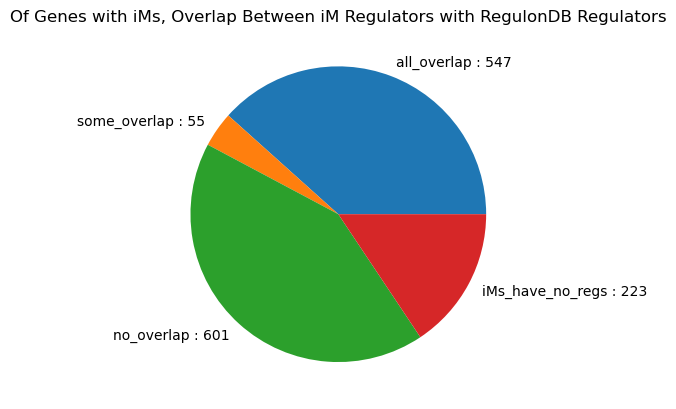

In [39]:
# pies!

num_iMs_to_ct = {}
for gene in log_tpm_df.index:
    if gene not in gene_to_iMs:
        num_iMs = 0
    else:
        num_iMs = len(gene_to_iMs[gene])
    if num_iMs not in num_iMs_to_ct:
        num_iMs_to_ct.update({num_iMs : 0})
    num_iMs_to_ct[num_iMs] += 1

plt.pie(num_iMs_to_ct.values(), labels = [str(k)+' : '+str(v) for k, v in num_iMs_to_ct.items()])
plt.title('Number of iModulons per Gene')
plt.show()

# out of genes with iModulons, how many are actually regulated by the iM's regulators?
all_overlap = []
some_overlap = []
no_overlap = []
iMs_have_no_regs = []
for gene, iMs in gene_to_iMs.items():
    if gene not in TRN_df.columns:
        no_overlap.append(gene)
    else:
        regs = TRN_df.index[TRN_df[gene] != 0].to_list()
        overlapped = 0
        iMs_have_regs = 0
        for iM in iMs:
            if iM not in iM_to_b_regulator:
                continue
            iMs_have_regs += 1
            if len(set(iM_to_b_regulator[iM]).intersection(regs)) > 0:
                overlapped += 1
        if iMs_have_regs == 0:
            iMs_have_no_regs.append(gene)
        elif iMs_have_regs == overlapped:
            all_overlap.append(gene)
        elif overlapped == 0:
            no_overlap.append(gene)
        else:
            some_overlap.append(gene)
labels = [
    'all_overlap : '+str(len(all_overlap)),
    'some_overlap : '+str(len(some_overlap)),
    'no_overlap : '+str(len(no_overlap)),
    'iMs_have_no_regs : '+str(len(iMs_have_no_regs)),
]
plt.pie([len(all_overlap), len(some_overlap), len(no_overlap), len(iMs_have_no_regs)], labels = labels)
plt.title('Of Genes with iMs, Overlap Between iM Regulators with RegulonDB Regulators')
plt.show()

In [89]:
# I need to greatly expand the saved_flags.csv dataframe to enable the model to run on all of these
saved_flags = pd.read_csv('../data/saved_flags.csv', index_col = 0)
defaults = {
    'force_rerun': True,
    'sanity_plots': True,
    'grid_use': -7,
    'basal_bool': False,
    'basal_or_hard_val': 'basal',
    'hard_val': 10.0,
    'use_zerod_A_matrix': True,
    'initial_guess_ratio': 0.8,
    'use_target_range': False,
    'target_range': '[-1, 3]',
    'base_cInhibitor_val': 0.2,
    'base_cActivator_val': 0.2,
    'auto_set_max_range': True,
    'additional_tolerance': 0.2,
    'cActivator': '[-4, 2]',
    'cInhibitor': '[-4, 2]',
    'run_greedy': True,
    'neg_grid_toss_OR_zero': 'toss',
    'seed': 42.0,
    'n_ind': 100.0,
    'mu': 100.0,
    'lambda_': 100.0,
    'cxpb': 0.6,
    'cx_prob': 0.6,
    'mutpb': 0.4,
    'mt_prob': 0.1,
    'n_gen': 100.0,
    'verbose': False,
    'n_iter': 5.0,
    'max_steps': 30.0,
    'n_rounds': 100.0
}

# decide if the regulators are positive or negative regulators of their iModulons
reg_to_iM_to_act_inh = {}
for iM, b_regs in iM_to_b_regulator.items():
    for b_reg in b_regs:
        if b_reg not in reg_to_iM_to_act_inh:
            reg_to_iM_to_act_inh.update({b_reg : {'act' : [], 'inh' : []}})
        try:
            # get correlation between regulator and iM
            corr = np.corrcoef(precise_log_tpm_df.loc[b_reg], A.loc[iM])[0][1]
            # does regulator promote or inhibit genes of iM more
            act_inh = 0
            for gene in iM_to_genes[iM]:
                if gene not in TRN_df.columns:
                    continue
                act_inh += TRN_df.loc[b_reg][gene]
            if (corr > 0 and act_inh > 0) or (corr < 0 and act_inh < 0):
                reg_to_iM_to_act_inh[b_reg]['act'].append(iM)
            else:
                reg_to_iM_to_act_inh[b_reg]['inh'].append(iM)
        except:
            print(iM+' : '+b_reg)
            
        # is it more of a promoter or inhibitor of genes in the iModulon?

for gene in all_overlap+some_overlap:
    # need to set act_iM, inh_iM, and basal_conditions
    iMs = gene_to_iMs[gene]
    good_iMs = set(iM_to_b_regulator.keys()).intersection(iMs)
    
    # I have my iMs now, now to decide what is an activator and what is an inhibitor
    promoter_iMs = []
    inhibitor_iMs = []
    for iM in good_iMs:
        if M.loc[gene][iM] > 0:
            positive_weight = True
        else:
            positive_weight = False
            
    # NOTE: Gaoyuan's stuff will greatly simplify this, instead just implement that and then:
    # positive gene weight means activator
    # negative gene weight means inhibitor
    
# selecting basal conditions - eventually to be overwritten by Griff's model
# the basal condition should be no regulation
for iM, genes in gene_to_iMs.items():
    if iM not in iM_to_b_regulator.keys():
        continue # not a good iModulon for mapping
        
    # gather all genes promot
    
    # if inhibited : find condition with max expression
    # if promoted : 


GlpR : b3423
Cbl+CysB : b1987b1275


In [87]:
# apparetnly gaoyuan has some magic to solve this, so i'll see what dan says at the meeting tomorrow